<a href="https://colab.research.google.com/github/kat-tian/Machine-Learning-Practice/blob/master/Dissertation_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Brief Overview of Dissertation Stats

In this notebook, I am using data collected from American participants from MTurk. The participants are measured for IND-COL at the individual level. Those higher in individualism are expected to generally prefer recommendations from a generic recommender system (i.e., 'recommended for you') and those higher in collectivism are expected to prefer recommendations from a friend (e.g., 'recommended by Alex'). 

The study follows a 2(individualism vs. collectivism) X 2(friend vs. generic recommender) quasi-experimental design.

### Cleaning & Function Definitions [hide]
*Note to Kat: Drop the participants not passing participation requirements

In [26]:
#imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

!pip install researchpy
import researchpy as rp
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import anderson
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.graphics.gofplots import qqplot

from google.colab import files
from IPython.display import Image
%matplotlib inline

In [0]:
#read data
df = pd.read_csv('Clean_EN_IND.csv').drop(columns=['Unnamed: 0'])

In [0]:
#write stats functions
def effect_size(aov):
  'take result from aov table, return with effect size'
  aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
  aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
  aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
  
  cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
  aov = aov[cols]
  return aov

def plot_interaction(df,dependent, independent_a, independent_b):
  print('Interaction plot for {}~{}*{}\n'.format(dependent,independent_a,independent_b))
  interaction_plot(df[independent_a], df[independent_b], df[dependent])
  plt.show()
  return

#fit model with interaction, model overall sig and summary
def anova_interaction(df, dependent, independent_a, independent_b):
  '''Find interaction between dv and two ivs. Dv and ivs must be str.
  Prints significance for overall interaction model and model summary.
  '''
  model = ols('{} ~ C({})*C({})'.format(dependent, independent_a, independent_b), df).fit()
  print('interaction for {}~{}*{}'.format(dependent, independent_a, independent_b))
  print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
  print('\n Interaction Model Summary:')
  print(model.summary())
  print('\n Interaction ANOVA Table')
  res =  (sm.stats.anova_lm(model, typ= 2))
  print(res)
  print('\n Interaction ANOVA Effect Size')
  print(effect_size(res))
  return

#fit model with no interaction, model overall sig and summary
def anova_main_effects(df, dependent, independent_a, independent_b):
  '''Find main effects for dv and two ivs. Dv and ivs must be str.
  Prints significance for overall main effects model and model summary.
  '''
  model = ols('{} ~ C({})+C({})'.format(dependent, independent_a, independent_b), df).fit()
  print('main effects for {}~{}+{}'.format(dependent, independent_a, independent_b))
  print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
  print('\n Main Effects Model Summary:')
  print(model.summary())
  print('\n Main Effects ANOVA Table')
  res =  (sm.stats.anova_lm(model, typ= 2))
  print(res)
  print('\n Main Effects ANOVA Effect Size')
  print(effect_size(res))
  return

#post-hoc tukey HSD
def tukey_HSD(df, dependent,independent):
  '''dep and ind must be str'''
  print('tukey HSD for dv: {} and iv: {}\n'.format(dependent,independent))
  mc = statsmodels.stats.multicomp.MultiComparison(df[dependent], df[independent])
  mc_results = mc.tukeyhsd()
  print(mc_results)
  return

#difference in mean between two groups
def mean_diff(df,dependent,independent):
  '''dep and ind must be str'''
  print('mean diff in {} grouped by {}\n'.format(dependent,independent))
  groupby= df.groupby(independent)
  for group, value in groupby[dependent]:
    print(group, value.mean())
  return

## Descriptive Stats
* Print the descriptive statistics
* Plot distributions

In [13]:
print('DESCRPTIVE STATS\n')
df.describe()

DESCRPTIVE STATS



,languages_selected,age,sex,country_born_selected,ethnicity,nationality_selected,education_selected,people_defined_attributes_individuals,people_independent_social_groups,individuals_groups_can_separated,individual_goals_more_group_goals,individuals_behaviors_individual_goals,individual_cannot_sacrificed,individual_more_responsibilities,win_versus_harmonize,success_competition,competition_more_harmony,people_should_freewill,disagree_follow_your_opinion,individuality_morerespected_conformity,character_attended_school,character_least_similar,character_most_similar,re_character_attended_school,re_character_least_similar,re_character_most_similar,similar_john,similar_alex,identity_john,identity_alex,pens_important,pens_not_matter*,pens_important_life,pens_choose_carefully,pens_use_matters,pens_important_decison,number_recomendations,expensive_pen,cheap_pen,buy_pen,try_pen,vist_pen,recommend_pen,appealing,informative,useful,positive,good,favorable,attractive,exciting,clear,sophisticated,coherent,high_quality,attitude_dsesign,attitude_trustworthiness,attitude_reliability,recommendations_dependable,recommendations_reliable,recommendations_trustworthy,recommendations_sincere,random_id,avg_ind,avg_adjective,avg_involvment,avg_purchase_intention,avg_attitude,avg_trust
count,268.0,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,1.0,35.108209,1.444030,2.085821,1.794776,1.048507,5.335821,5.298507,5.201493,5.466418,4.940299,5.320896,4.746269,4.555970,4.485075,4.716418,4.406716,5.123134,4.843284,4.854478,1.768657,1.216418,1.761194,0.283582,0.291045,0.332090,3.832090,5.649254,4.000000,5.626866,5.037313,2.861940,4.850746,5.029851,4.936567,4.768657,1.917910,2.007463,3.776119,4.958955,5.179104,4.843284,4.727612,3.406716,3.223881,3.500000,3.518657,3.555970,3.488806,3.421642,3.119403,3.652985,3.108209,3.567164,3.507463,5.171642,5.257463,5.305970,5.141791,5.186567,5.182836,5.324627,5444.865672,4.947809,4.580846,3.422575,4.927239,5.245025,5.208955
std,0.0,10.584750,0.505255,0.478082,1.397848,0.325964,1.843885,1.151647,1.383584,1.278895,1.372612,1.260763,1.541858,1.952776,1.742765,1.680966,1.886943,1.366995,1.503327,1.485668,0.431254,0.421553,0.435832,0.582027,0.597431,0.674423,1.833361,1.130162,1.898156,1.225030,1.533187,1.868216,1.649004,1.630424,1.704721,1.762762,0.424855,0.504605,0.849250,1.656390,1.646018,1.796186,1.814543,1.119570,1.221786,1.197688,1.123309,1.148457,1.149770,1.219926,1.376881,1.139564,1.320909,1.104623,1.276385,1.393006,1.410548,1.420701,1.407061,1.451683,1.489088,1.492500,2630.354194,1.057884,1.252751,1.012146,1.543630,1.297616,1.344706
min,1.0,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1028.000000,1.000000,0.833333,0.000000,0.000000,0.000000,0.000000
25%,1.0,28.000000,1.000000,2.000000,1.000000,1.000000,5.000000,5.000000,4.000000,5.000000

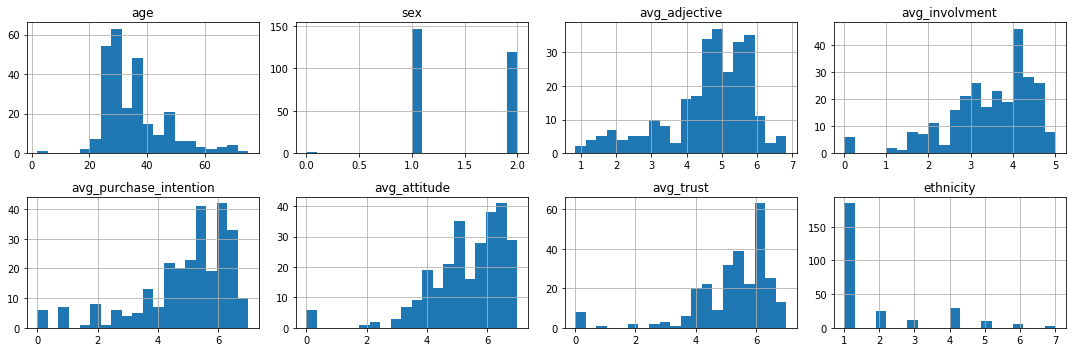

In [21]:
cols = ['age','sex','avg_adjective', 'avg_involvment', 
        'avg_purchase_intention','avg_attitude', 'avg_trust','ethnicity']

fig, ax = plt.subplots(2,4, figsize=(15,5))
ax=ax.ravel()

for idx,col in enumerate(cols):
  df.hist(col,ax=ax[idx], bins=20)

plt.tight_layout()

## Checking Assumptions of Normality 
* Q-Q plots suggest have skew but are close enough to normal for ANOVA
* Perform Anderson-Darling test to statistically check for gaussian dist, does not pass, but ANOVA is robust against skew

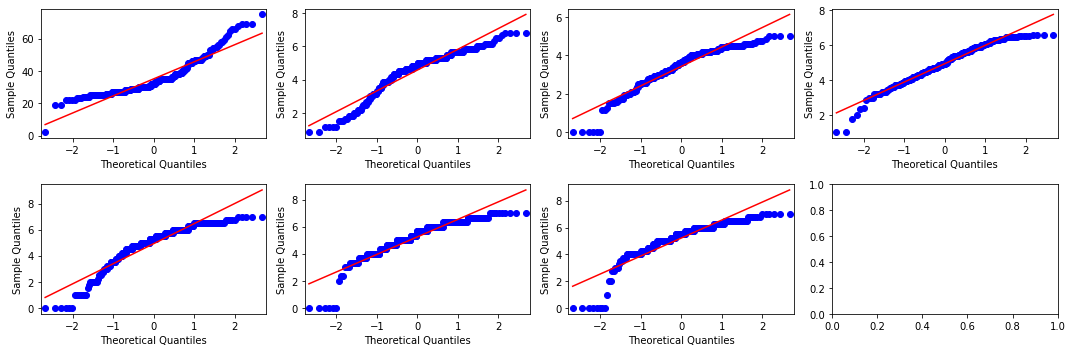

In [42]:
cols = ['age','avg_adjective', 'avg_involvment', 'avg_ind',
        'avg_purchase_intention','avg_attitude', 'avg_trust']
fig, ax = plt.subplots(2,4, figsize=(15,5))
ax = ax.ravel()

for idx, col in enumerate(cols):
  qqplot(df[col], line='s', ax=ax[idx])
plt.tight_layout()

In [77]:
result = anderson(df['avg_adjective'].array)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 8.032
15.000: 0.568, data does not look normal (reject H0)
10.000: 0.647, data does not look normal (reject H0)
5.000: 0.776, data does not look normal (reject H0)
2.500: 0.905, data does not look normal (reject H0)
1.000: 1.076, data does not look normal (reject H0)


## Methodology 

### Sample and Procedure
Two hundred and ninety-three US residents who identified their nationality as American and native language as English (44.71% Female; *M*$_{age}$ = 76.29) were recruited from Amazon's Mechanical Turk(MTurk). However, several surveys were left incomplete and some respondents entered their age incorrectly (e.g., 1990 instead of 27). After removing incomplete surveys and adjusting for outliers in age, two hundred and sixty-eight participants (44.78% Female; *M*$_{age}$ = 35.12) with usable data remained. The majority of respondents identified English as the language their most fluent langague (94.75%) and all were located in the US (100%) according to their IP adress. 

Participants were first requested to respond to 12 questions measuring their level of indiviudalism or collectivism. A reduced version of the individualism-collectivism scale (SOURCE), origially consisting of 18 questions, was used. Respondents were requested to provide a scalar answer, with options nominally ranged between 1(strongly disagree) and 7(strongly agree), to questions gauging their levels of individualism-collectivism (e.g., 'people should follow their free-will instead of group norms', 'individual goals are more important than group goals', and 'people are independent of social groups') on a 7-point Likert scale. Answers higher in mangintude correspond with greater levels of individualism whereas answers lower in magnitude corresponds with lower individualism and higher collectivism.

Following measurement questions, participants were randomly assigned to either imagine a fictitious friend named "Alex" and view products recommended by this character (friend recommendation condition) or to simply view a generic recommender system (generic recommendation condition). Those assigned to the friend condition were told to: "imagine that someone named "Alex" attended the same high school as you and lived in the same region. Since you and Alex attended the same high school, you have had similar teachers, courses and experiences. Alex is very similar to you and your friends. Alex also attended high school roughly around the same time as you." Afterwards, participants rated how similar in social identity they felt to Alex relative (xx% similar to Alex). 

Upon completion of the manipulation checks, participants were randomly shown one of two recommender systems. Either the products recommended on the page were stated to be "recommended by Alex" or to generically be "recommended by you". They then reported their purchase intentions of the products, attitude toward the recommendation system, how much they liked the design of the recommender, and their trust in the recommendations on a scale of 1(very unlikely/strongly disagree) to 7(very likely/strongly disagree). Finally, the participants were debriefed on the purpose of the study and thanked for their participation. 





In [27]:
uploaded=files.upload()

Saving control.png to control.png


Experimental Condtion: Friend Recommendation



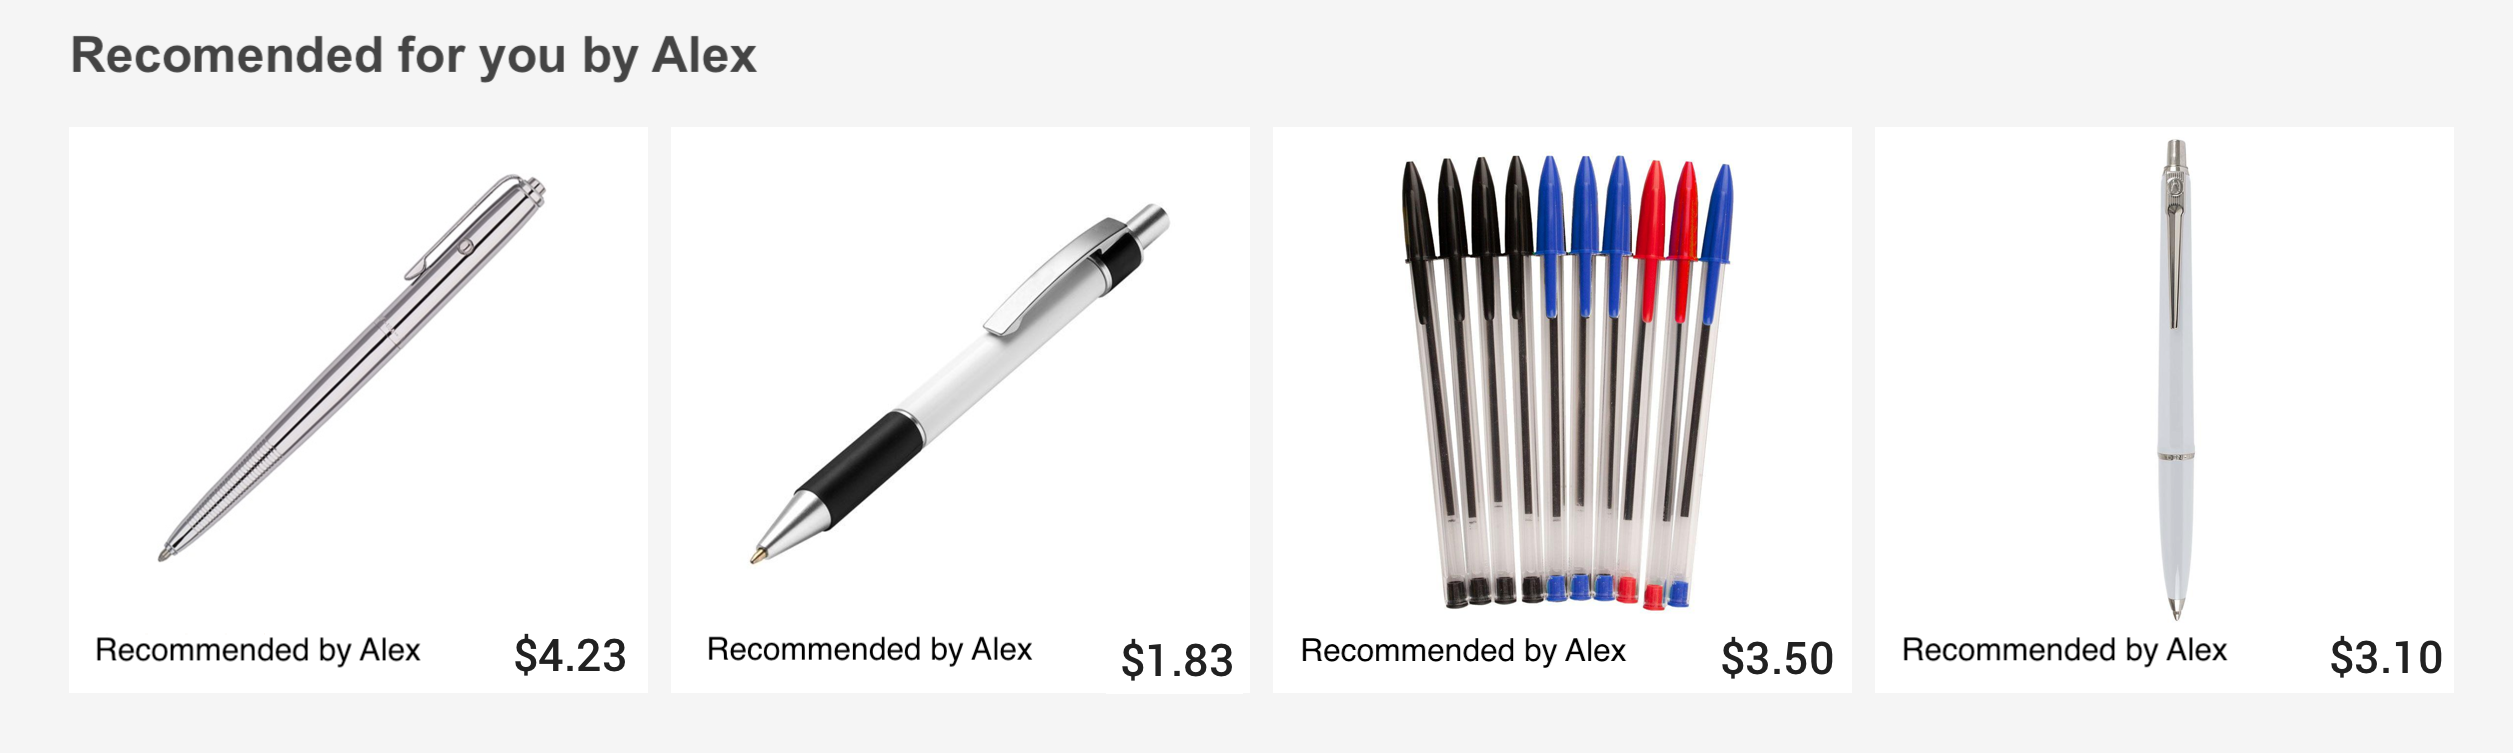

In [30]:
print('Experimental Condtion: Friend Recommendation\n')
Image('recomended_Alex_new_en.png', width=900)

Control Condtion: Generic Recommendation



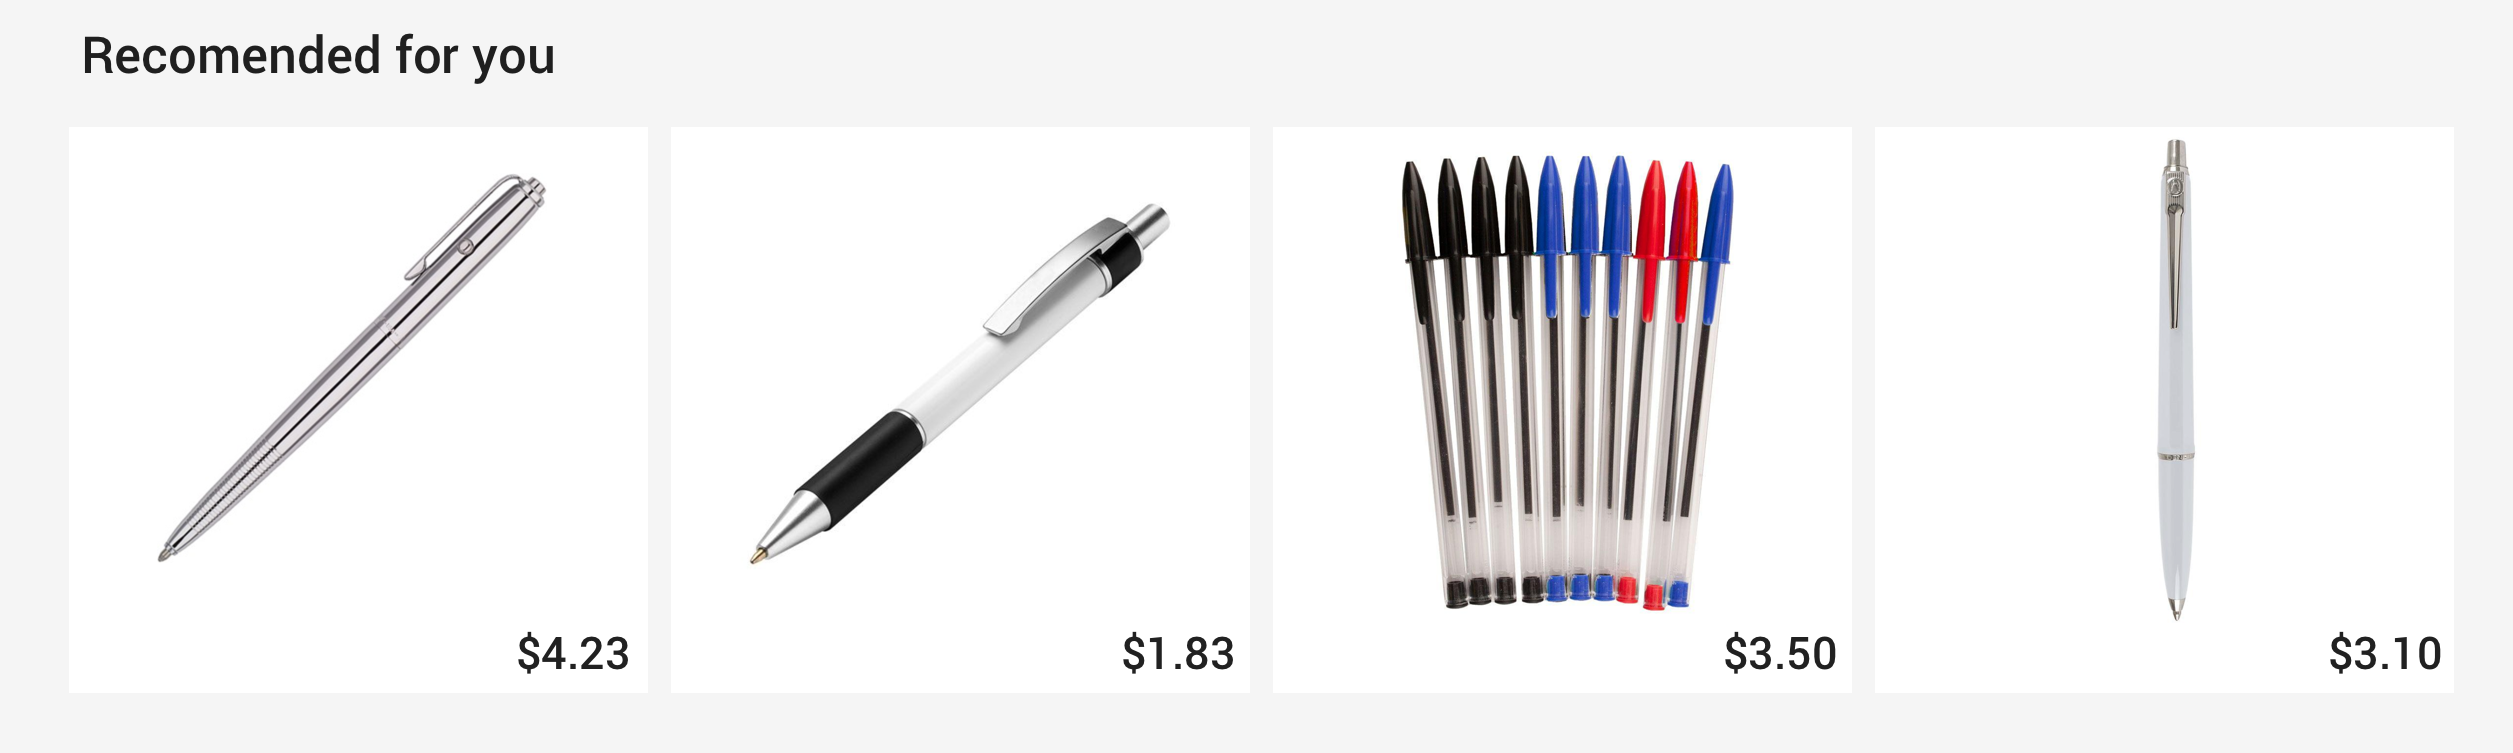

In [31]:
print('Control Condtion: Generic Recommendation\n')
Image('control.png', width=900)

## Hypothesis 1: Purchase Intention 

Participants scoring higher on collectivism (vs. individualism) will report higher purchase intentions when the products are recommended by a friend (vs. generic recommendation).

#### Interaction effect

* Overall model of condition (friend vs. generic) and IND-COL level (ind vs. col) on purchase intentions is significant: Overall model F( 3, 264) =  16.125, p =  0.0000
* Looking at ANOVA table, we can see that the interaction effect is not significant, the condition is not significant, but the level of IND-COL is significant. 
*Even if the effects are significant, partial eta-squared and omega-squared reveal insignificant effect size.

In [35]:
#avg_purchase_intention interaction effects
anova_interaction(df, 'avg_purchase_intention', 'condition', 'ind_class')

interaction for avg_purchase_intention~condition*ind_class
Overall model F( 3, 264) =  16.125, p =  0.0000

 Interaction Model Summary:
                              OLS Regression Results                              
Dep. Variable:     avg_purchase_intention   R-squared:                       0.155
Model:                                OLS   Adj. R-squared:                  0.145
Method:                     Least Squares   F-statistic:                     16.13
Date:                    Sun, 22 Dec 2019   Prob (F-statistic):           1.18e-09
Time:                            13:26:43   Log-Likelihood:                -473.58
No. Observations:                     268   AIC:                             955.2
Df Residuals:                         264   BIC:                             969.5
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                                  

* After printing a plot of the condition and level of IND-COL on the DV purchase intention, it is clear that there is no interaction effect

Interaction plot for avg_purchase_intention~condition*ind_class



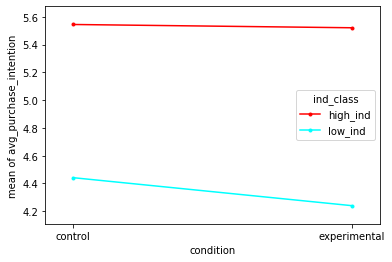

In [41]:
plot_interaction(df, 'avg_purchase_intention', 'condition', 'ind_class')

#### Main Effects

* Model for interaction revealed the interaction effect is not significant. We should now look at the main effects directly. 

* Main effect of condition on purchase intention is not significant, p > 0.05

* Main effect of IND-COL on purchase intention is sigificant, p < 0.05

* Despite significant main effect, effect-size calculations are tiny (p~0), suggests that the effect is not meaningful

In [43]:
#purchase intentions main effects
anova_main_effects(df, 'avg_purchase_intention', 'condition', 'ind_class')

main effects for avg_purchase_intention~condition+ind_class
Overall model F( 2, 265) =  24.127, p =  0.0000

 Main Effects Model Summary:
                              OLS Regression Results                              
Dep. Variable:     avg_purchase_intention   R-squared:                       0.154
Model:                                OLS   Adj. R-squared:                  0.148
Method:                     Least Squares   F-statistic:                     24.13
Date:                    Sun, 22 Dec 2019   Prob (F-statistic):           2.37e-10
Time:                            13:38:26   Log-Likelihood:                -473.71
No. Observations:                     268   AIC:                             953.4
Df Residuals:                         265   BIC:                             964.2
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                

#### Post-Hoc Tukey-HSD

* Post-Hoc Tukey-HSD reveals that groups do not differ from each other

In [50]:
tukey_HSD(df,'avg_purchase_intention','condition')

tukey HSD for dv: avg_purchase_intention and iv: condition

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1    group2    meandiff p-adj   lower  upper  reject
----------------------------------------------------------
control experimental  -0.2377 0.2081 -0.6086 0.1332  False
----------------------------------------------------------


In [0]:
tukey_HSD(df,'avg_purchase_intention','ind_class')

#### Mean differences
* When we plot the mean differences, we see there is not a striking difference either based on condition. 
* There is a difference based on IND-COL. However, when we calcualte the effect size, we find that it may be significant, but does not have a meaningful effect.

In [0]:
mean_diff(df,'avg_purchase_intention','condition')

In [0]:
generic_mean = np.mean(grouped_df.get_group('control')['avg_purchase_intention'])
friend_mean = np.mean(grouped_df.get_group('experimental')['avg_purchase_intention'])

generic_std = np.std(grouped_df.get_group('control')['avg_purchase_intention'])
friend_std = np.std(grouped_df.get_group('experimental')['avg_purchase_intention'])

In [0]:
# Create lists for the plot
title = 'Mean Difference in Condition on Purchase Intention'
y_title = 'Average Purchase Intention'
groups = ['Generic Conditon', 'Friend Condition']
x_pos = np.arange(len(groups))
CTEs = [generic_mean, friend_mean]
error = [generic_std, friend_std]

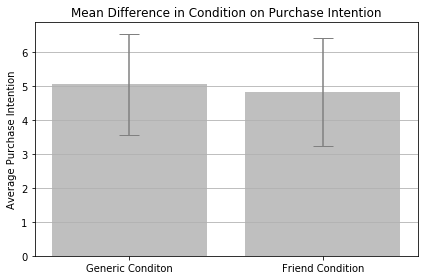

In [78]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, color='grey', ecolor='grey', capsize=10)
ax.set_ylabel(y_title)
ax.set_xticks(x_pos)
ax.set_xticklabels(groups)
ax.set_title(title)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

In [79]:
mean_diff(df,'avg_purchase_intention','ind_class')

mean diff in avg_purchase_intention grouped by ind_class

high_ind 5.533834586466165
low_ind 4.32962962962963


In [0]:
grouped_df = df.groupby('ind_class') 

In [0]:
ind_mean = np.mean(grouped_df.get_group('high_ind')['avg_purchase_intention'])
col_mean = np.mean(grouped_df.get_group('low_ind')['avg_purchase_intention'])

ind_std = np.std(grouped_df.get_group('high_ind')['avg_purchase_intention'])
col_std = np.std(grouped_df.get_group('low_ind')['avg_purchase_intention'])

In [0]:
# Create lists for the plot
title = 'Mean Difference in IND-COL on Purchase Intention'
y_title = 'Average Purchase Intention'
groups = ['Individualism', 'Collectivism']
x_pos = np.arange(len(groups))
CTEs = [ind_mean, col_mean]
error = [ind_std, col_std]

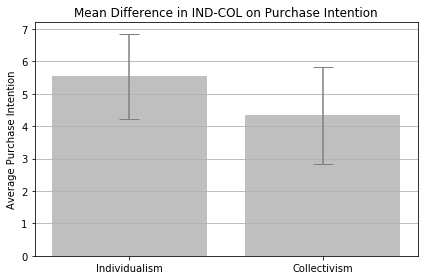

In [85]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, color='grey', ecolor='grey', capsize=10)
ax.set_ylabel(y_title)
ax.set_xticks(x_pos)
ax.set_xticklabels(groups)
ax.set_title(title)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()